In [1]:
# importing os module 
import os
#import the pandas library and aliasing as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
# This functions as whether the user wants to save data. It uses recursion to force the user to give a valid answer
def yesno(question):
    """Simple Yes/No Function."""
    prompt = f'{question} ? (y/n): '
    ans = input(prompt).strip().lower()
    if ans not in ['y', 'n']:
        print(f'{ans} is invalid, please try again...')
        return yesno(question)
    if ans == 'y':
        return True
    return False

In [3]:
# This function generates the rmsdpp, rmsdpe, and energy data for plotting
def GenerateData(fname, path):
    rmsdpp_file = open(path + '/rmsdpp.dat', "x")
    with open(fname, 'r') as f:
        for line in f.readlines():
            if 'RMSDPP' in line:
                rmsdpp_file.write(str(line.split()[-1]) + '\n')
    rmsdpp_file.close()


    rmsdpe_file = open(path + '/rmsdpe.dat', "x")
    with open(fname, 'r') as f:
        for line in f.readlines():
            if 'RMSDPE' in line:
                rmsdpe_file.write(str(line.split()[-1]) + '\n')
    rmsdpe_file.close()


    energy_file = open(path + '/energy.dat', "x")
    with open(fname, 'r') as f:
        for line in f.readlines():
            if ('smt' in fname):
                if ('The Energy for This Iteration is:' in line):
                    energy_file.write(str(line.split()[6]) + '\n')
            else:
                if 'SubSCF Loop, Total Energy = ' in line:
                    energy_file.write(str(line.split()[7]) + '\n')
    energy_file.close()

In [4]:
# This function reads the log file, extract key information and puts it in the dataframe
def fillDF(log_file,df):
    temp = log_file.split("/")[-1][:-4].split('_')

    index = log_file.split("/")[-1][:-4].replace('_smt','').replace('_stw','')

    Alg = temp[1]

    # if the algorithm is simultaneous, we fill in the structure, basis information, and # of smt iterations
    if (Alg == 'smt'):
        df.loc[index]['Structure'] = temp[0]
        df.loc[index]['EBasis'] = temp[2]
        df.loc[index]['PBasis'] = temp[3]

        with open(log_file, 'r') as f:
            for line in f.readlines():
                if 'NBasis=' in line:     
                    df.loc[index]['NEBasis'] = int(line.split()[1])
                    break

        with open(log_file, 'r') as f:
            for line in f.readlines():
                if 'NEO NBasis=' in line:     
                    df.loc[index]['NPBasis'] = int(line.split()[2])
                    break

        E_SMT = 0.00
        with open(log_file, 'r') as f:
            for line in f.readlines():
                if 'NEO-SCF Converged After Iteration #' in line:     
                    df.loc[index]['NSMT'] = int(line.split()[5])
                if ('The Energy for This Iteration is:' in line):
                    E_SMT = float(line.split()[6])
        df.loc[index]['E-SMT'] =  E_SMT        
                    
                    
    # if the algorithm is stepwise, we fill in the # of sub-scf iterations
    if (Alg == 'stw'):

        Elec_Iter = 0
        Prot_Iter = 0
        E_STW = 0.00
        
        with open(log_file, 'r') as f:
            for line in f.readlines():
                if 'Electronic Converged after Iteration #' in line:     
                    Elec_Iter += int(line.split()[5])
                if 'Protonic Converged after Iteration #' in line:     
                    Prot_Iter += int(line.split()[5])
                if ('SubSCF Loop, Total Energy = ' in line):
                    E_STW = float(line.split()[7])

        df.loc[index]['NSTW-E'] = Elec_Iter
        df.loc[index]['NSTW-P'] = Prot_Iter
        df.loc[index]['E-STW'] =  E_STW       

In [5]:
# This function calculates the theoretical computational cost based on # of fock builds and basis size
def getCompCost(NEFock,NPFock,NEBasis,NPBasis):
    return NEFock*np.power(NEBasis,4) + NPFock*np.power(NPBasis,4) + (NEFock+NPFock)*np.power(NEBasis,2)*np.power(NPBasis,2)

In [8]:
# Main code starts here

output_dir = '/Users/aodongliu/LiGroup/gaussian/neo_scf_data_processing/OutputFiles/h2o/'
data_dir = '/Users/aodongliu/LiGroup/gaussian/neo_scf_data_processing/Data/'


full_path_log_files = []

for subdir, dirs, files in os.walk(output_dir):
    for file in files:
        #print(file)
        if file.endswith(".log"):
            full_name = os.path.join(subdir, file)
            full_path_log_files.insert(0,full_name)      
#            name_without_path = full_name.split("/")[-1] 
#            log_files.insert(0,name_without_path)        

In [9]:
saveData = yesno("Do you want to save the data")
print(f'you answer was: {saveData}')

Do you want to save the data ? (y/n): n
you answer was: False


In [10]:
if (saveData):
    for log_file in full_path_log_files:
        destination_dir = log_file.split("/")[-1][:-4]
        path = os.path.join(data_dir, destination_dir)
        os.mkdir(path)
        GenerateData(log_file,path)

In [11]:
structures = ['h2o']
elec_basis_pool = ['3-21g','6-311g','6-31g','def2svp','4-31g','6-311g(d,p)','def2tzvp','cc-pvdz','cc-pvtz','cc-pvqz','def2qzvp']
prot_basis_pool = ['protsp','pb4d','pb4f1','pb5d','pb4f2','pb5f','pb5g']

In [12]:
Calculations = []
for structure in structures:
    for prot_basis in prot_basis_pool:                                          
        for elec_basis in elec_basis_pool: 
            elec_basis = elec_basis.replace('-', '').replace('(', '').replace(')', '').replace(',', '')
            prot_basis = prot_basis.replace('-', '').replace('(', '').replace(')', '').replace(',', '')
            temp = structure + '_' + elec_basis + '_' + prot_basis
            Calculations.append(temp)

In [13]:
df = pd.DataFrame(columns=['Structure',
                          'EBasis',
                          'PBasis',
                          'NEBasis',
                          'NPBasis',
                          'NSMT',
                          'NSTW-E',
                          'NSTW-P',
                          'E-SMT',
                          'E-STW',
                           'E-Diff',
                           'Basis Ratio',
                           'Cost Ratio'
                          ],index= Calculations)
df

,Structure,EBasis,PBasis,NEBasis,NPBasis,NSMT,NSTW-E,NSTW-P,E-SMT,E-STW,E-Diff,Basis Ratio,Cost Ratio
h2o_321g_protsp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
h2o_6311g_protsp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
h2o_631g_protsp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
h2o_def2svp_protsp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
h2o_431g_protsp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
h2o_def2tzvp_pb5g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
h2o_ccpvdz_pb5g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
h2o_ccpvtz_pb5g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
h2o_ccpvqz_pb5g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
for log_file in full_path_log_files:
    fillDF(log_file,df)

In [15]:
df

,Structure,EBasis,PBasis,NEBasis,NPBasis,NSMT,NSTW-E,NSTW-P,E-SMT,E-STW,E-Diff,Basis Ratio,Cost Ratio
h2o_321g_protsp,h2o,321g,protsp,13,8,17,97,89,-75.409151,-75.409151,NaN,NaN,NaN
h2o_6311g_protsp,h2o,6311g,protsp,19,8,18,95,84,-75.826374,-75.826374,NaN,NaN,NaN
h2o_631g_protsp,h2o,631g,protsp,13,8,18,93,83,-75.797666,-75.797666,NaN,NaN,NaN
h2o_def2svp_protsp,h2o,def2svp,protsp,24,8,25,107,105,-75.786301,-75.786301,NaN,NaN,NaN
h2o_431g_protsp,h2o,431g,protsp,13,8,18,93,83,-75.721675,-75.721675,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
h2o_def2tzvp_pb5g,h2o,def2tzvp,pb5g,43,110,130,NaN,NaN,-75.958829,NaN,NaN,NaN,NaN
h2o_ccpvdz_pb5g,h2o,ccpvdz,pb5g,24,110,138,NaN,NaN,-75.928256,NaN,NaN,NaN,NaN
h2o_ccpvtz_pb5g,h2o,ccpvtz,pb5g,58,110,144,NaN,NaN,-75.963387,NaN,NaN,NaN,NaN
h2o_ccpvqz_pb5g,h2o,ccpvqz,pb5g,115,110,190,NaN,NaN,-75.977245,NaN,NaN,NaN,NaN


In [16]:
# Do some post processing to get the energy difference, computational cost, and cost ratio
df['E-Diff'] = df['E-SMT'] - df['E-STW'] 
df['Cost Ratio'] = getCompCost(df['NSMT'],df['NSMT'],df['NEBasis'],df['NPBasis'])  / getCompCost(df['NSTW-E'],df['NSTW-P'],df['NEBasis'],df['NPBasis'])
df['Basis Ratio'] = df['NPBasis'] / df['NEBasis']

# Prints in a pretty manner
df.style.format({'E-Diff': "{:.2E}",'E-STW': "{:.2f}",'E-SMT': "{:.2f}",'Basis Ratio': "{:.2f}",'Cost Ratio': "{:.2f}"})

,Structure,EBasis,PBasis,NEBasis,NPBasis,NSMT,NSTW-E,NSTW-P,E-SMT,E-STW,E-Diff,Basis Ratio,Cost Ratio
h2o_321g_protsp,h2o,321g,protsp,13,8,17,97,89,-75.41,-75.41,-9.04E-12,0.62,0.18
h2o_6311g_protsp,h2o,6311g,protsp,19,8,18,95,84,-75.83,-75.83,-2.22E-11,0.42,0.19
h2o_631g_protsp,h2o,631g,protsp,13,8,18,93,83,-75.80,-75.80,-9.55E-12,0.62,0.20
h2o_def2svp_protsp,h2o,def2svp,protsp,24,8,25,107,105,-75.79,-75.79,-2.69E-11,0.33,0.23
h2o_431g_protsp,h2o,431g,protsp,13,8,18,93,83,-75.72,-75.72,-9.61E-12,0.62,0.20
h2o_6311gdp_protsp,h2o,6311gdp,protsp,30,8,26,93,90,-75.87,-75.87,-3.82E-11,0.27,0.28
h2o_def2tzvp_protsp,h2o,def2tzvp,protsp,43,8,26,96,96,-75.89,-75.89,-4.76E-11,0.19,0.27
h2o_ccpvdz_protsp,h2o,ccpvdz,protsp,24,8,24,93,85,-75.85,-75.85,-5.37E-12,0.33,0.26
h2o_ccpvtz_protsp,h2o,ccpvtz,protsp,58,8,27,108,123,-75.89,-75.89,-5.15E-11,0.14,0.25
h2o_ccpvqz_protsp,h2o,ccpvqz,protsp,115,8,34,98,123,-75.90,-75.90,-6.61E-11,0.07,0.35


In [17]:
df['Iter Ratio'] = df['NSMT'] / (df['NSTW-E'] + df['NSTW-P'])

In [18]:
df['Iter Ratio'].mean()

0.1808722484915369

In [19]:
df['Cost Ratio'].max()

0.607256070214594

In [21]:
df_h2o = df.dropna(axis=0)
df_h2o_clean = df_h2o[ abs(df_h2o['E-Diff']) <= 0.0001]

In [36]:
df_h2o_clean[df_h2o_clean['EBasis']=='ccpvtz']

,Structure,EBasis,PBasis,NEBasis,NPBasis,NSMT,NSTW-E,NSTW-P,E-SMT,E-STW,E-Diff,Basis Ratio,Cost Ratio,Iter Ratio
h2o_ccpvtz_protsp,h2o,ccpvtz,protsp,58,8,27,108,123,-75.887721,-75.887721,-0.0,0.137931,0.249353,0.116883
h2o_ccpvtz_pb4d,h2o,ccpvtz,pb4d,58,46,102,113,564,-75.962583,-75.962583,-0.0,0.793103,0.355221,0.150665
h2o_ccpvtz_pb4f1,h2o,ccpvtz,pb4f1,58,60,116,136,617,-75.962862,-75.962862,-0.0,1.034483,0.301573,0.15405
h2o_ccpvtz_pb4f2,h2o,ccpvtz,pb4f2,58,74,126,145,743,-75.963359,-75.963359,-0.0,1.275862,0.244454,0.141892


In [34]:
a = np.array(df_h2o_clean[df_h2o_clean['EBasis']=='ccpvtz']['Cost Ratio'])

In [35]:
a

array([0.249353420406052, 0.35522091365035624, 0.3015727008284603,
       0.24445357436318818], dtype=object)

In [32]:
df_h2o_clean[df_h2o_clean['EBasis']=='ccpvqz']

,Structure,EBasis,PBasis,NEBasis,NPBasis,NSMT,NSTW-E,NSTW-P,E-SMT,E-STW,E-Diff,Basis Ratio,Cost Ratio,Iter Ratio
h2o_ccpvqz_protsp,h2o,ccpvqz,protsp,115,8,34,98,123,-75.901237,-75.901237,-0.0,0.069565,0.346513,0.153846
h2o_ccpvqz_pb4d,h2o,ccpvqz,pb4d,115,46,106,117,585,-75.975002,-75.975002,-0.0,0.4,0.583856,0.150997
h2o_ccpvqz_pb4f1,h2o,ccpvqz,pb4f1,115,60,146,158,766,-75.975971,-75.975971,-0.0,0.521739,0.506782,0.158009
h2o_ccpvqz_pb4f2,h2o,ccpvqz,pb4f2,115,74,146,159,818,-75.977083,-75.977083,-0.0,0.643478,0.414811,0.149437


In [59]:
df_h2o_clean[df_h2o_clean['PBasis']=='pb4f2']

,Structure,EBasis,PBasis,NEBasis,NPBasis,NSMT,NSTW-E,NSTW-P,E-SMT,E-STW,E-Diff,Basis Ratio,Cost Ratio,Iter Ratio
fhf_6311g_pb4f2,fhf,6311g,pb4f2,29,37,31,31,63,-199.478317,-199.478317,0.0,1.275862,0.609965,0.329787
fhf_def2svp_pb4f2,fhf,def2svp,pb4f2,33,37,36,31,84,-199.270193,-199.270193,0.0,1.121212,0.594857,0.313043
fhf_431g_pb4f2,fhf,431g,pb4f2,20,37,27,31,70,-199.202272,-199.202272,-0.0,1.85,0.44131,0.267327
fhf_6311gdp_pb4f2,fhf,6311gdp,pb4f2,42,37,31,32,84,-199.498233,-199.498233,-0.0,0.880952,0.5665,0.267241
fhf_def2tzvp_pb4f2,fhf,def2tzvp,pb4f2,68,37,34,32,69,-199.546982,-199.546982,-0.0,0.544118,0.840502,0.336634
fhf_ccpvdz_pb4f2,fhf,ccpvdz,pb4f2,33,37,33,31,68,-199.443038,-199.443038,-0.0,1.121212,0.639443,0.333333
fhf_ccpvtz_pb4f2,fhf,ccpvtz,pb4f2,74,37,32,31,61,-199.527422,-199.527422,0.0,0.5,0.864865,0.347826
fhf_ccpvqz_pb4f2,fhf,ccpvqz,pb4f2,140,37,32,33,69,-199.552322,-199.552322,-0.0,0.264286,0.905225,0.313725
fhf_def2qzvp_pb4f2,fhf,def2qzvp,pb4f2,144,37,33,32,76,-199.561139,-199.561139,-0.0,0.256944,0.950324,0.305556


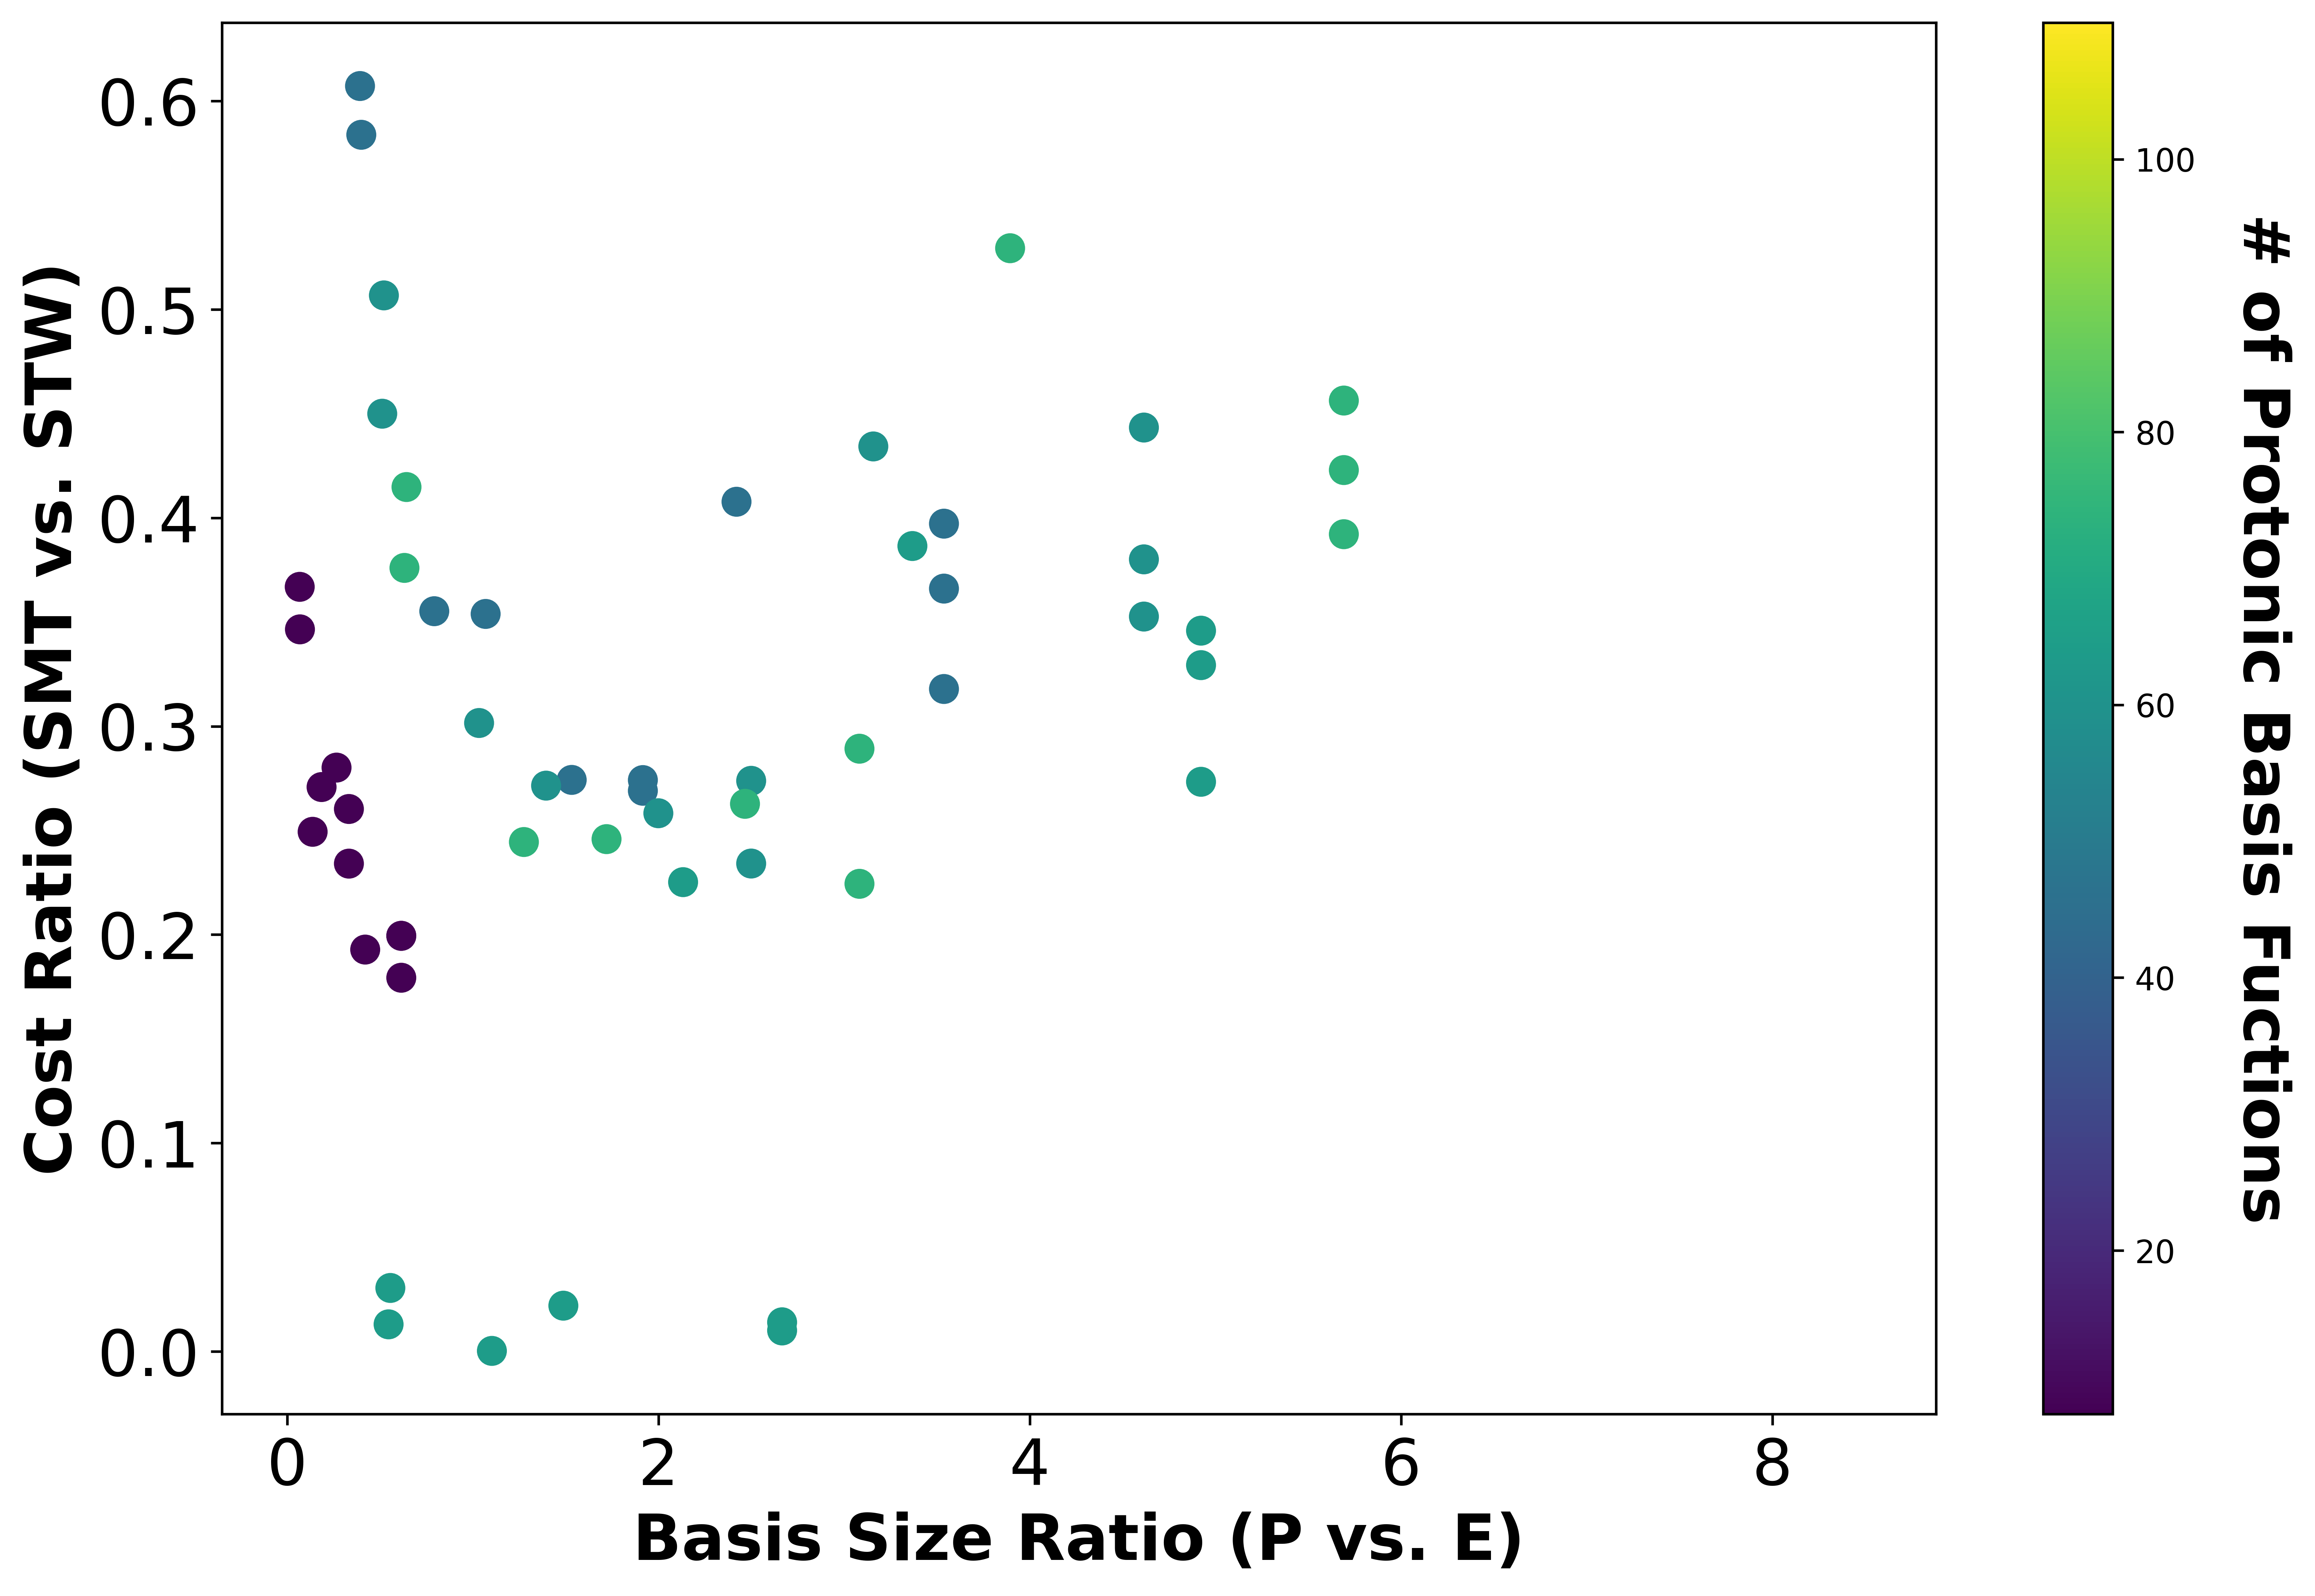

In [24]:
fig, ax = plt.subplots(figsize=(12,8), dpi=600)

artist = ax.scatter(df['Basis Ratio'],df['Cost Ratio'],c=df['NPBasis'],s=70)
ax.set_xlabel('Basis Size Ratio (P vs. E)',size=20,weight='bold')
ax.set_ylabel('Cost Ratio (SMT vs. STW)',size=20,weight='bold')
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
#ax.set_xticklabels(fontsize=20)
#ax.set_xlim(0,1)
#ax.set_yticklabels(fontsize=20)
cbar = plt.colorbar(artist, ax=[ax])
cbar.set_label('# of Protonic Basis Fuctions',size=20, weight='bold', labelpad=30, rotation=270)

#label_points(df['Basis Ratio'],df['Cost Ratio'],df['Structure'],df['EBasis'],df['PBasis'],ax)

plt.savefig('/Users/aodongliu/LiGroup/gaussian/neo_scf_data_processing/plots/cost_vs_basissize_h2o.pdf', dpi=600)
plt.show()

In [25]:
def label_points(x,y,struc,eb,pb,ax):
    a = pd.concat({'x': x, 'y': y, 'struc': struc,'eb': eb,'pb': pb}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+0.01, point['y']+0.005, str(point['struc'][0])+'|'+str(point['eb'])+'|'+str(point['pb']))

In [26]:
df_zoomin0to1 = df[df['Basis Ratio'] < 1]

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


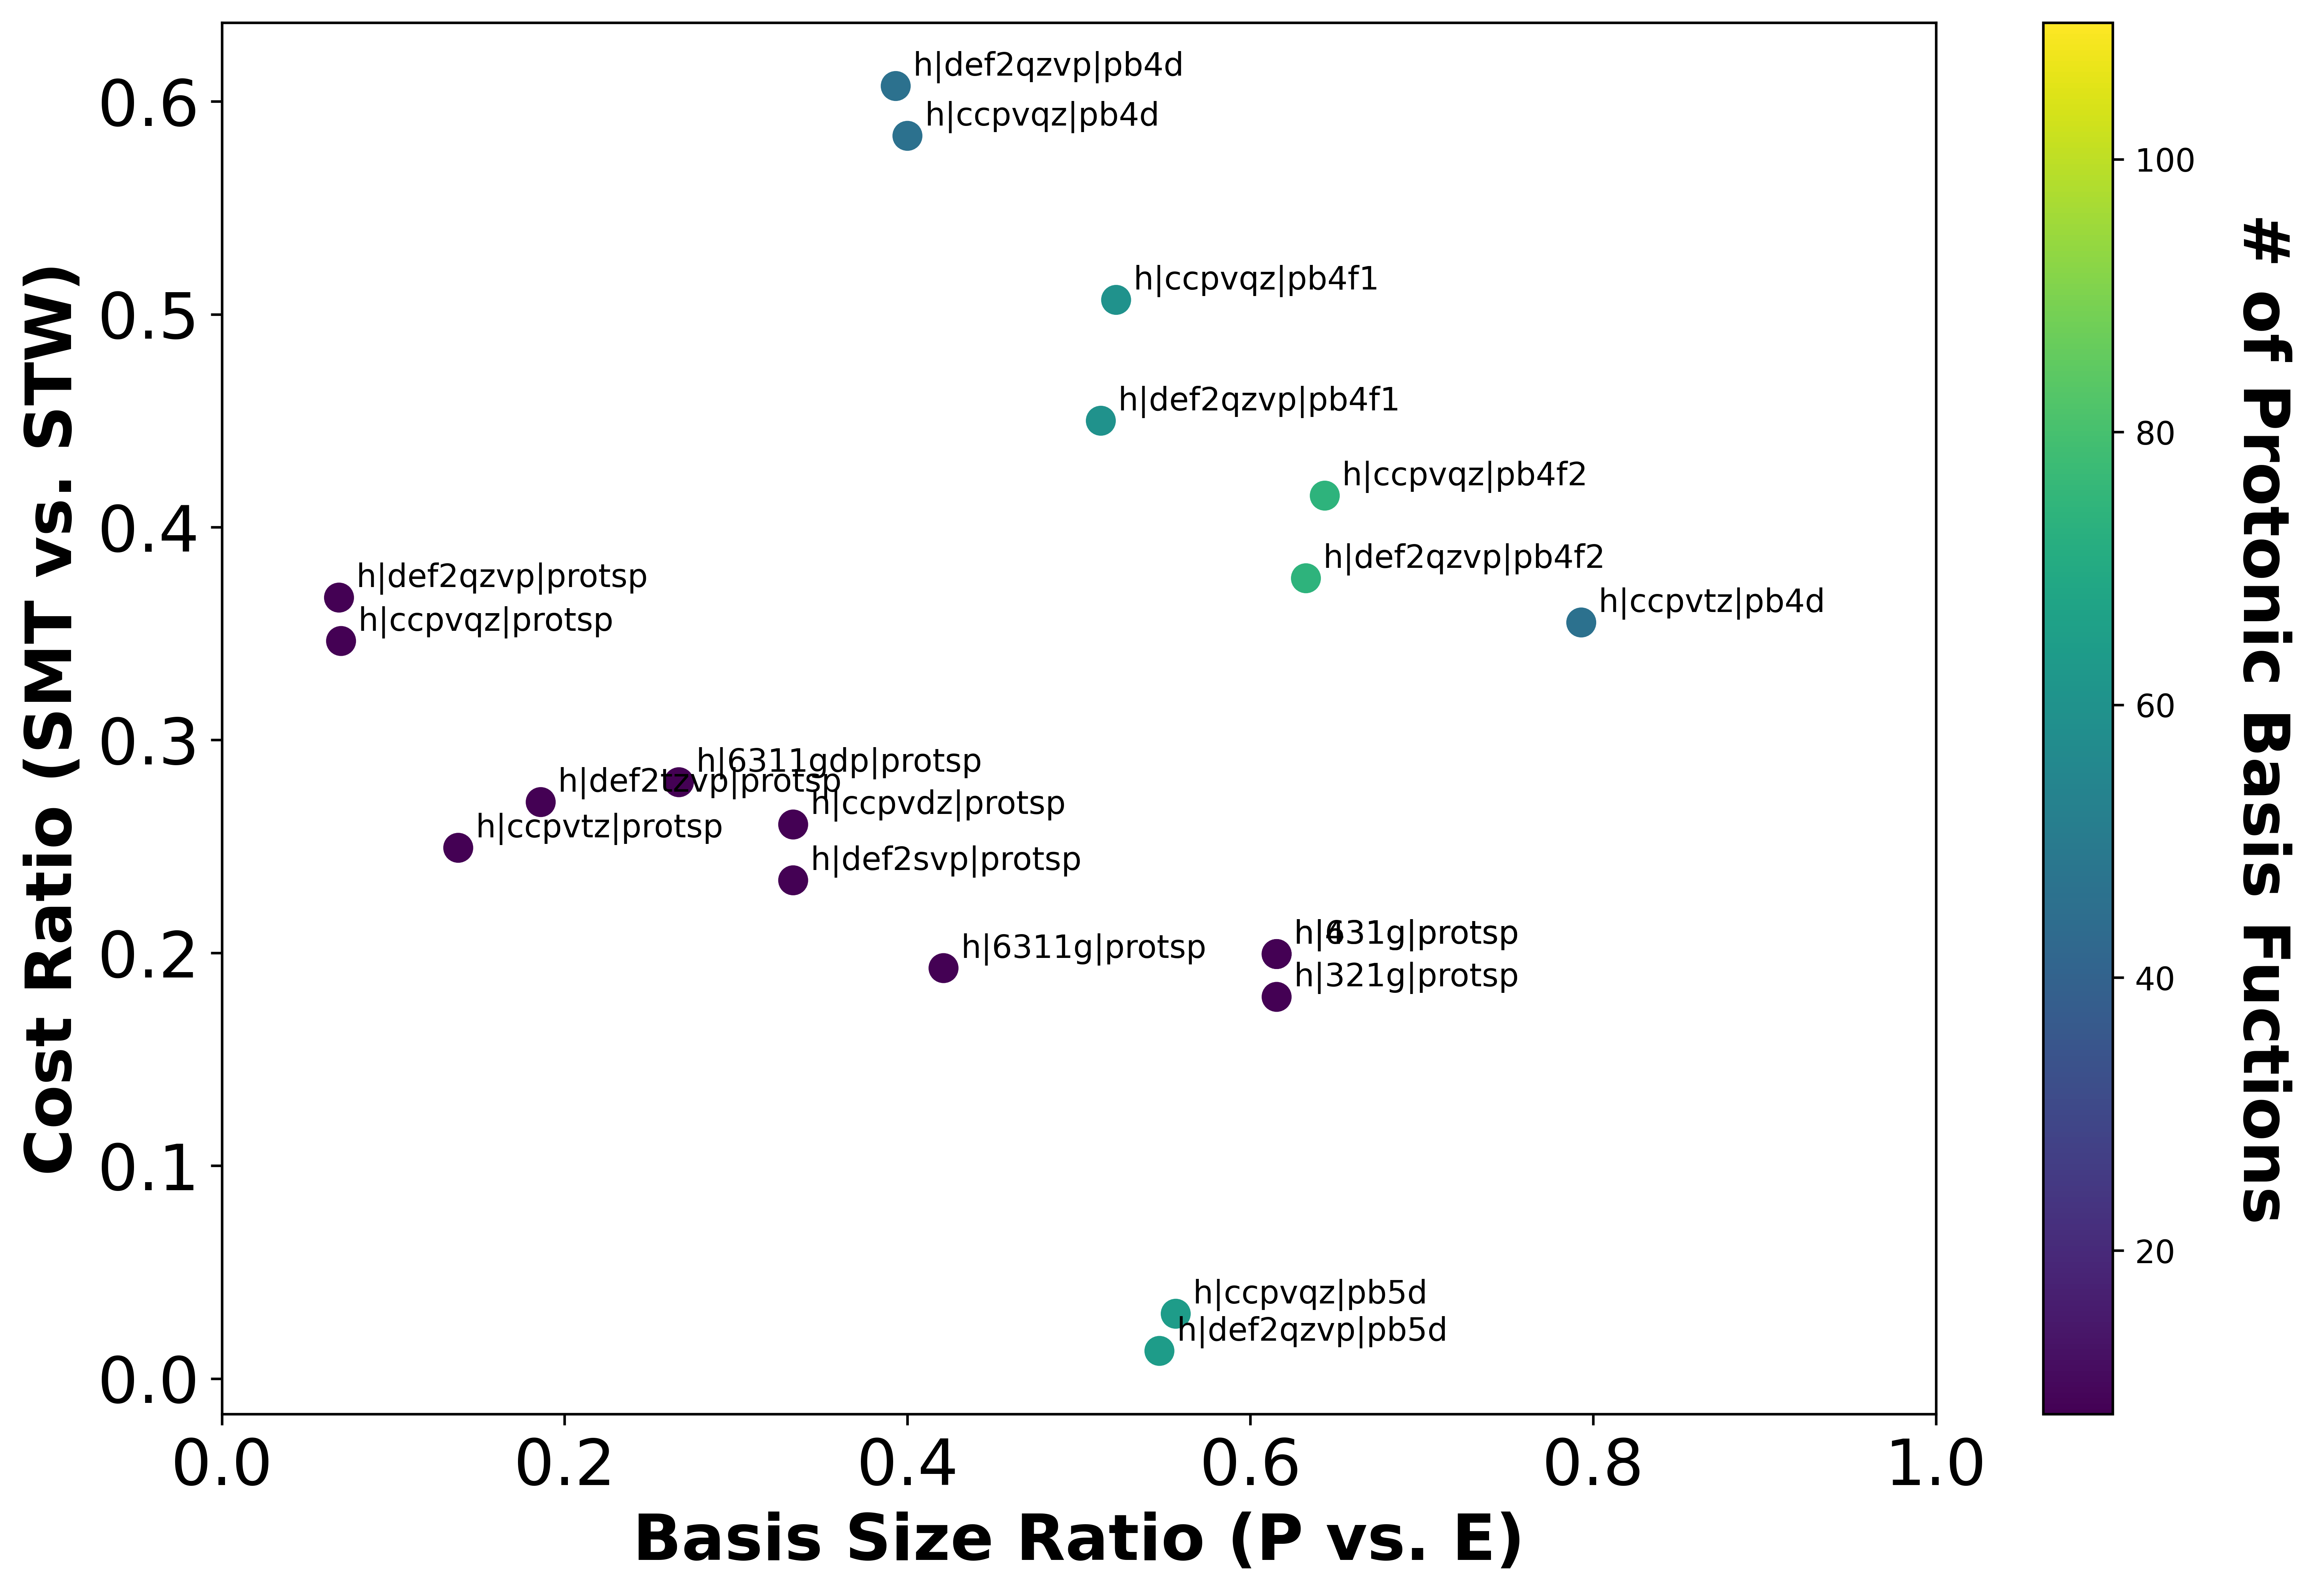

In [27]:
fig, ax = plt.subplots(figsize=(12,8), dpi=600)

artist = ax.scatter(df_zoomin0to1['Basis Ratio'],df_zoomin0to1['Cost Ratio'],c=df_zoomin0to1['NPBasis'],s=70)
ax.set_xlabel('Basis Size Ratio (P vs. E)',size=20,weight='bold')
ax.set_ylabel('Cost Ratio (SMT vs. STW)',size=20,weight='bold')
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
#ax.set_xticklabels(fontsize=20)
ax.set_xlim(0,1)
#ax.set_yticklabels(fontsize=20)
cbar = plt.colorbar(artist, ax=[ax])
cbar.set_label('# of Protonic Basis Fuctions',size=20, weight='bold', labelpad=30, rotation=270)

label_points(df_zoomin0to1['Basis Ratio'],df_zoomin0to1['Cost Ratio'],df_zoomin0to1['Structure'],df_zoomin0to1['EBasis'],df_zoomin0to1['PBasis'],ax)

plt.savefig('/Users/aodongliu/LiGroup/gaussian/neo_scf_data_processing/plots/cost_vs_basissize_coh2+hcn_zoomin0to1.pdf', dpi=600)
plt.show()

In [21]:
df_zoomin0to0p4 = df[df['Basis Ratio'] < 0.4]

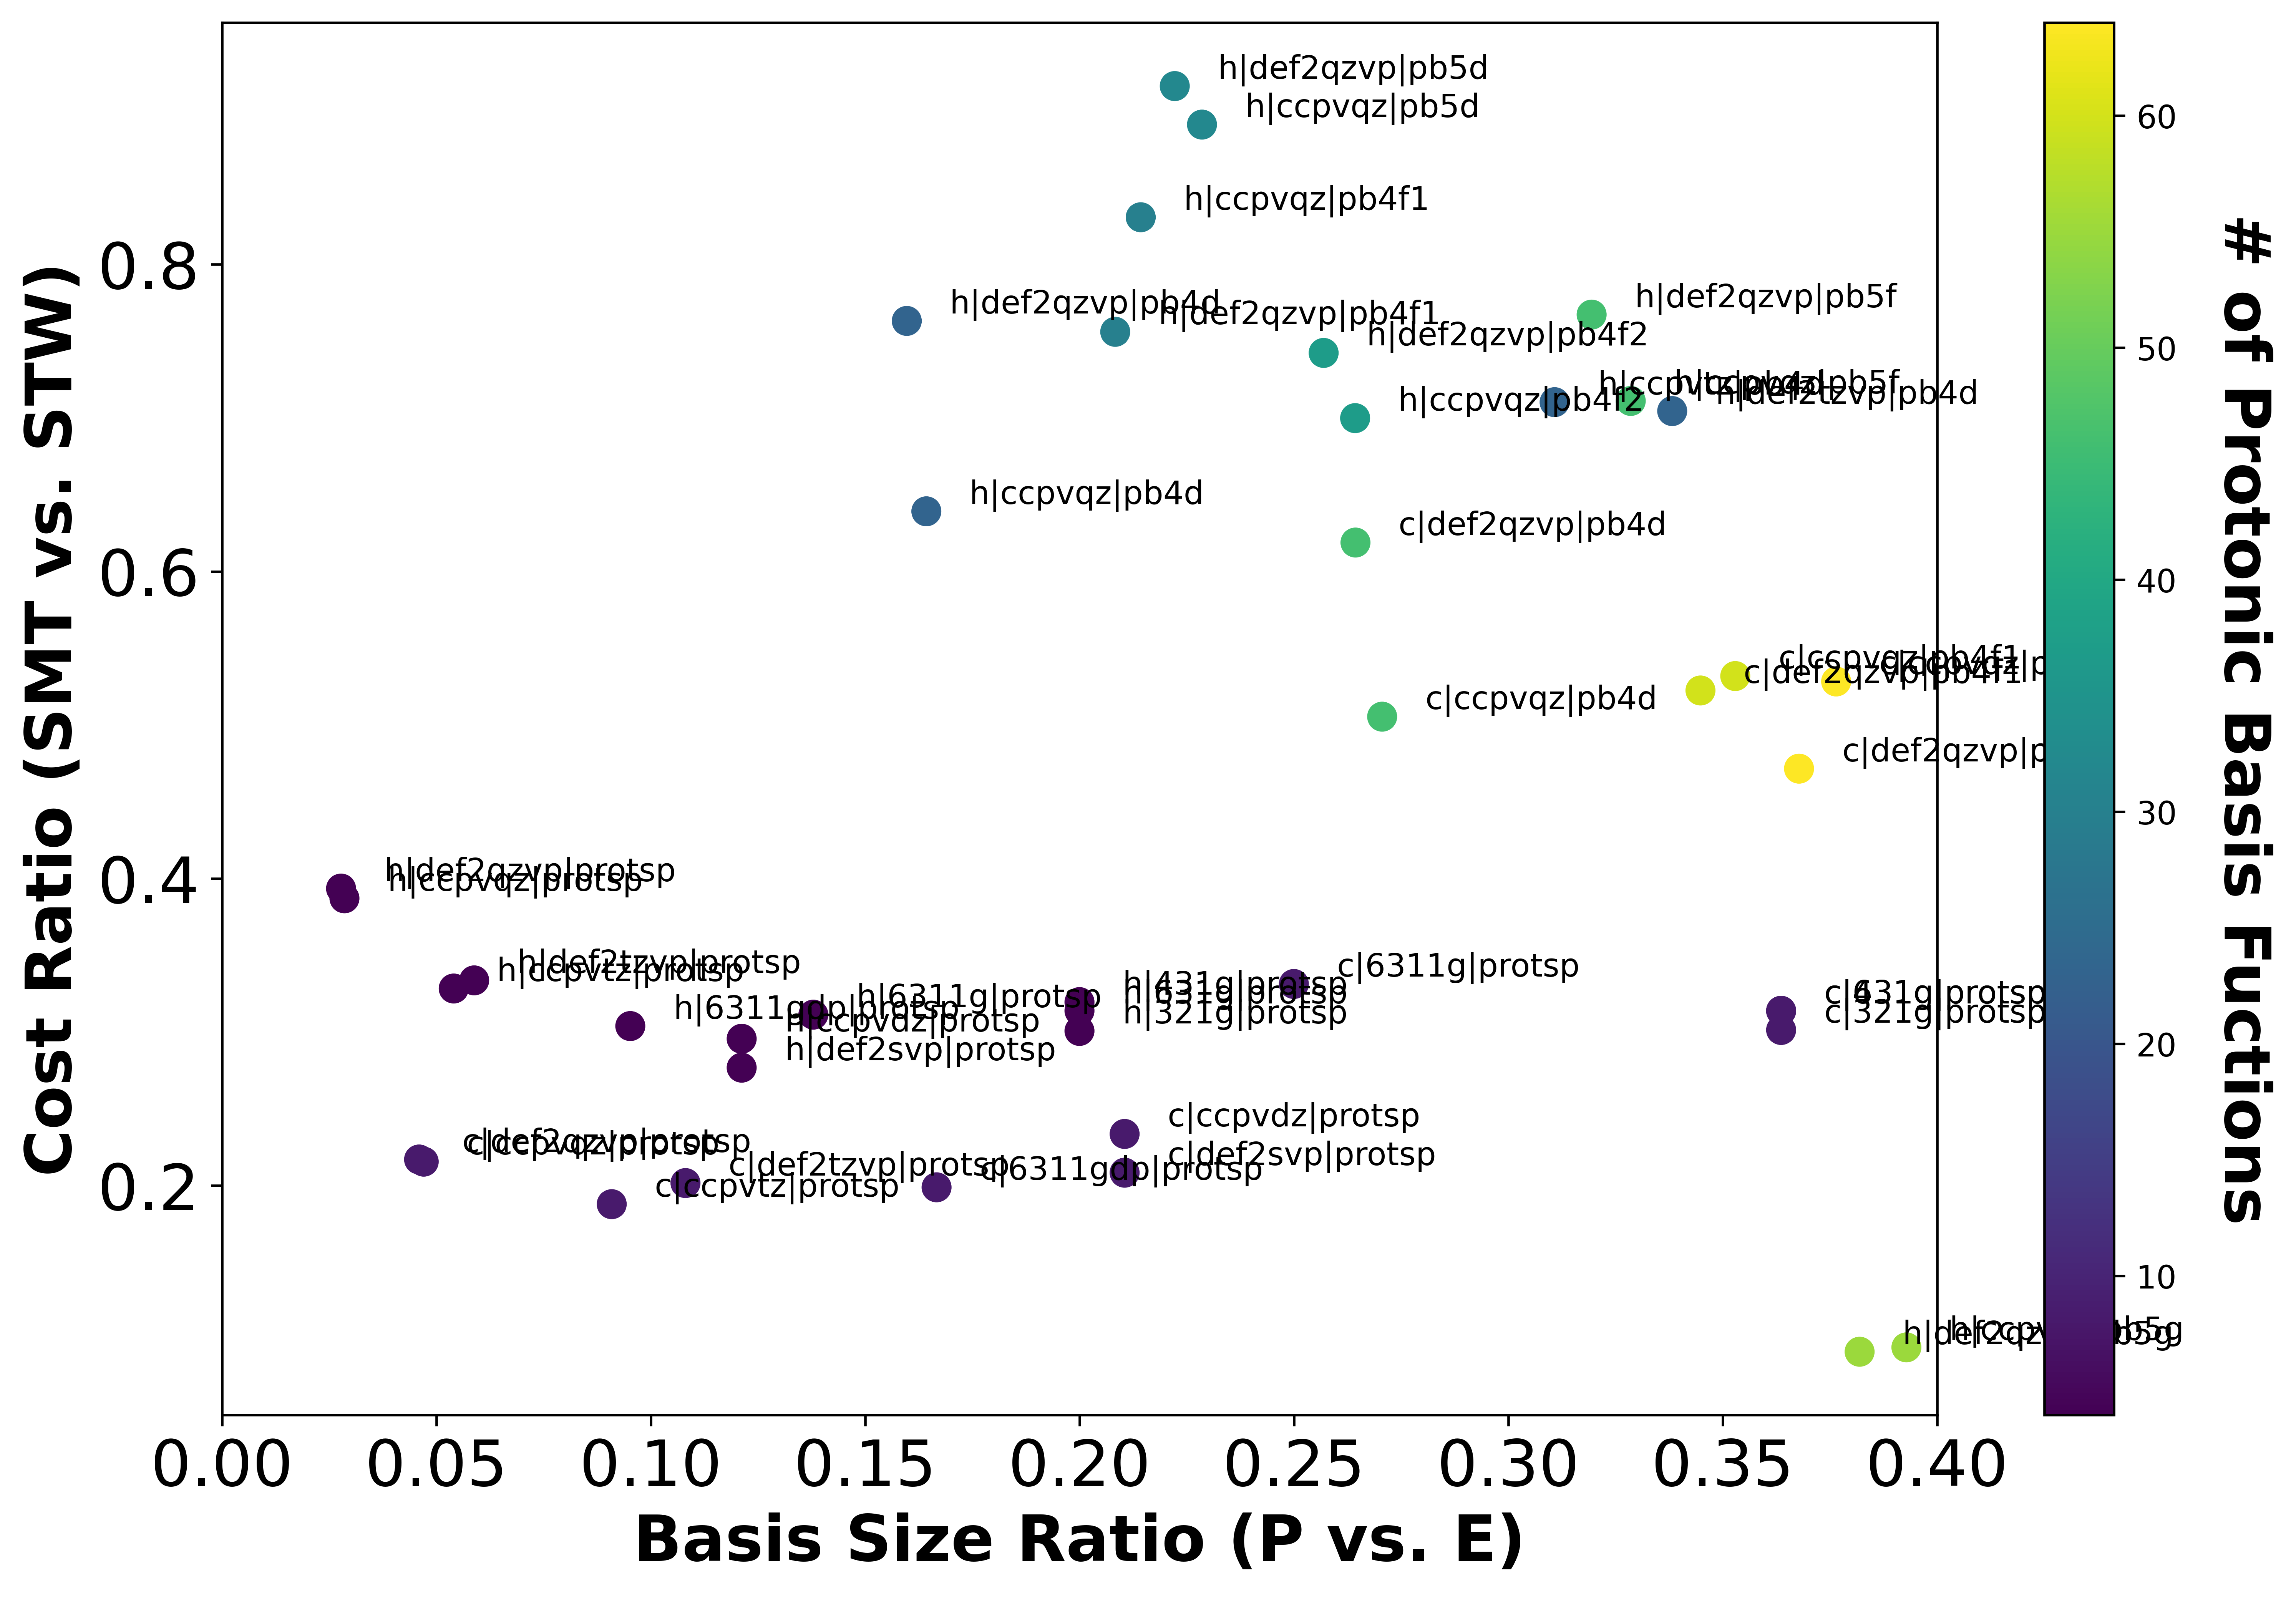

In [22]:
fig, ax = plt.subplots(figsize=(12,8), dpi=600)

artist = ax.scatter(df_zoomin0to0p4['Basis Ratio'],df_zoomin0to0p4['Cost Ratio'],c=df_zoomin0to0p4['NPBasis'],s=70)
ax.set_xlabel('Basis Size Ratio (P vs. E)',size=20,weight='bold')
ax.set_ylabel('Cost Ratio (SMT vs. STW)',size=20,weight='bold')
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
#ax.set_xticklabels(fontsize=20)
ax.set_xlim(0,0.4)
#ax.set_yticklabels(fontsize=20)
cbar = plt.colorbar(artist, ax=[ax])
cbar.set_label('# of Protonic Basis Fuctions',size=20, weight='bold', labelpad=30, rotation=270)

label_points(df_zoomin0to0p4['Basis Ratio'],df_zoomin0to0p4['Cost Ratio'],df_zoomin0to0p4['Structure'],df_zoomin0to0p4['EBasis'],df_zoomin0to0p4['PBasis'],ax)

plt.savefig('/Users/aodongliu/LiGroup/gaussian/neo_scf_data_processing/plots/cost_vs_basissize_coh2+hcn_zoomin0to0p4.pdf', dpi=600)
plt.show()

In [28]:
df_noprotsp = df.drop(df[df['PBasis'] == 'protsp'].index)

In [29]:
df_noprotsp

,Structure,EBasis,PBasis,NEBasis,NPBasis,NSMT,NSTW-E,NSTW-P,E-SMT,E-STW,E-Diff,Basis Ratio,Cost Ratio,Iter Ratio
h2o_321g_pb4d,h2o,321g,pb4d,13,46,81,52,271,-75.489254,-75.489254,-0.0,3.538462,0.317893,0.250774
h2o_6311g_pb4d,h2o,6311g,pb4d,19,46,76,48,210,-75.901385,-75.901385,-0.0,2.421053,0.407747,0.294574
h2o_631g_pb4d,h2o,631g,pb4d,13,46,80,50,232,-75.87703,-75.87703,-0.0,3.538462,0.366067,0.283688
h2o_def2svp_pb4d,h2o,def2svp,pb4d,24,46,108,107,472,-75.863186,-75.863186,-0.0,1.916667,0.27418,0.186528
h2o_431g_pb4d,h2o,431g,pb4d,13,46,82,49,219,-75.80111,-75.80111,-0.0,3.538462,0.397235,0.30597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
h2o_def2tzvp_pb5g,h2o,def2tzvp,pb5g,43,110,130,NaN,NaN,-75.958829,NaN,NaN,2.55814,NaN,NaN
h2o_ccpvdz_pb5g,h2o,ccpvdz,pb5g,24,110,138,NaN,NaN,-75.928256,NaN,NaN,4.583333,NaN,NaN
h2o_ccpvtz_pb5g,h2o,ccpvtz,pb5g,58,110,144,NaN,NaN,-75.963387,NaN,NaN,1.896552,NaN,NaN
h2o_ccpvqz_pb5g,h2o,ccpvqz,pb5g,115,110,190,NaN,NaN,-75.977245,NaN,NaN,0.956522,NaN,NaN


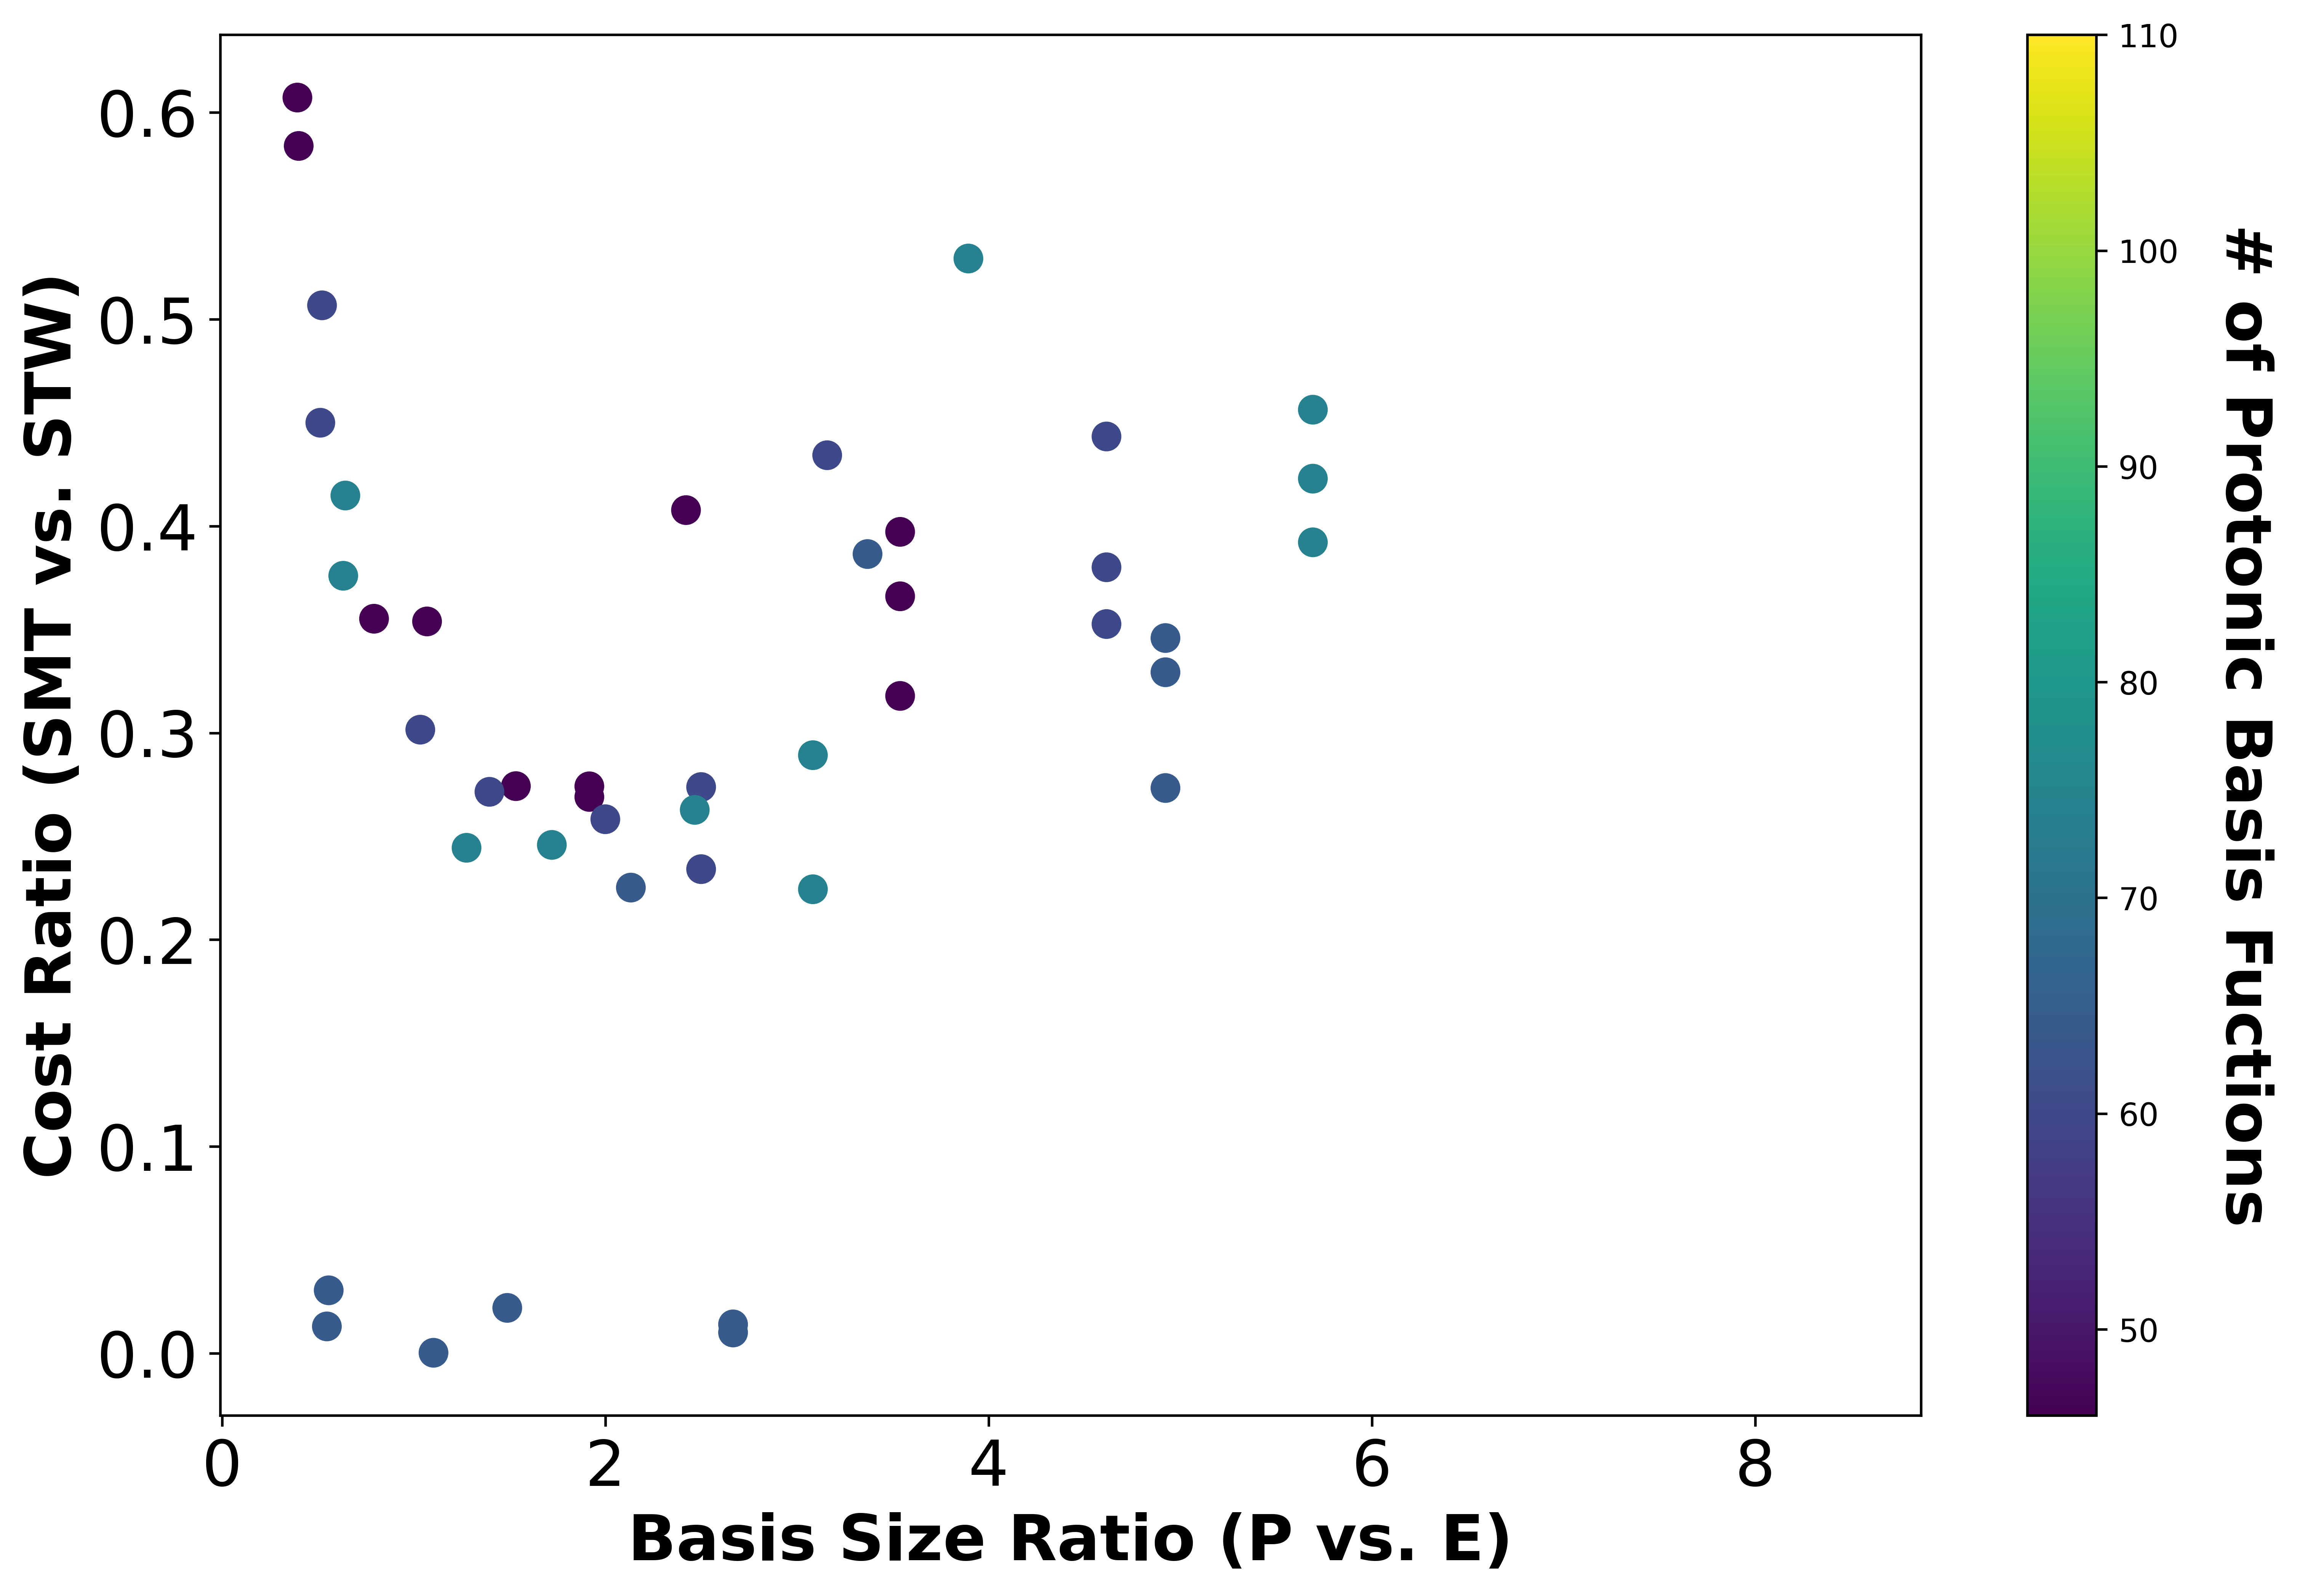

In [30]:
fig, ax = plt.subplots(figsize=(12,8), dpi=600)

artist = ax.scatter(df_noprotsp['Basis Ratio'],df_noprotsp['Cost Ratio'],c=df_noprotsp['NPBasis'],s=70)
ax.set_xlabel('Basis Size Ratio (P vs. E)',size=20,weight='bold')
ax.set_ylabel('Cost Ratio (SMT vs. STW)',size=20,weight='bold')
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
#ax.set_xticklabels(fontsize=20)
#ax.set_xlim(0,1)
#ax.set_yticklabels(fontsize=20)
cbar = plt.colorbar(artist, ax=[ax])
cbar.set_label('# of Protonic Basis Fuctions',size=20, weight='bold', labelpad=30, rotation=270)

#label_points(df_noprotsp['Basis Ratio'],df_noprotsp['Cost Ratio'],df_noprotsp['Structure'],df_noprotsp['EBasis'],df_noprotsp['PBasis'],ax)

plt.savefig('/Users/aodongliu/LiGroup/gaussian/neo_scf_data_processing/plots/cost_vs_basissize_coh2+hcn_noprotsp.pdf', dpi=600)
plt.show()

In [31]:


df_h2o_clean_new = df_h2o_clean.drop(df_h2o_clean[(df_h2o_clean['EBasis'] == '431g') | (df_h2o_clean['EBasis'] == '631g') | (df_h2o_clean['EBasis'] == 'ccpvdz') |  (df_h2o_clean['PBasis'] == 'protsp') | (df_h2o_clean['PBasis'] == 'pb5g')].index)

EBasis_list = []
PBasis_list = []
Cost_list = []

LastE = 0
LastP = 0
for index, row in df_h2o_clean_new.iterrows():
    if (row['NPBasis'] != LastP and not(row['NPBasis'] in PBasis_list)):
        PBasis_list.append(row['NPBasis'])
        LastP = row['NPBasis']
        
    if (row['NEBasis'] != LastE and not(row['NEBasis'] in EBasis_list)):
        EBasis_list.append(row['NEBasis'])
        LastE = row['NEBasis']
        
    Cost_list.append(row['Cost Ratio'])
    
x = np.array(EBasis_list)
y = np.array(PBasis_list)
z = np.array(Cost_list)
X, Y = np.meshgrid(x,y)
Z = z.reshape(len(y),len(x))

fig, ax = plt.subplots(1,1,figsize=(12,12))

cm = plt.cm.get_cmap('Blues')


im = ax.pcolormesh(x.astype('str'), y.astype('str'), Z, cmap=cm, shading='nearest',edgecolors='k', linewidths=2)
# Display the colorbar for each subplot
cbar = fig.colorbar(im, ax=ax)

ax.set_xlabel('Electronic Basis Function Size',size=20,weight='bold')
ax.set_ylabel('Protonic Basis Function Size',size=20,weight='bold')
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

cbar.ax.set_title('Comp Cost Ratio',size=17,weight='bold' )

plt.savefig('/Users/aodongliu/LiGroup/gaussian/neo_scf_data_processing/plots/coh2_heatmap.pdf', dpi=600)
plt.show()

ValueError: cannot reshape array of size 27 into shape (4,8)